In [9]:
import cityscapesscripts.helpers.labels as labels
import tensorflow as tf
from tensorflow import keras
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from functools import partial
from datetime import datetime
from tensorflow.keras.mixed_precision import experimental as mixed_precision

#Set Memory Growth to alleviate memory issues
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
#Change policy to fp16 to use Tensor Cores
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
mixed_precision.set_policy(policy)

#Use the XLA compiler
'''
As per Tensorflow documentation
A simplest way to start using XLA in TensorFlow models is to enable auto-clustering,
which automatically finds clusters (connected subgraphs) within the TensorFlow graph
which can be compiled and executed using XLA.
'''
#tf.config.optimizer.set_jit(True)


CITYSCAPES_LABELS = [label for label in labels.labels if -1 < label.trainId < 255]
CITYSCAPES_COLORS = [label.color for label in CITYSCAPES_LABELS]
CITYSCAPES_IDS = [label.trainId for label in CITYSCAPES_LABELS]
CITYSCAPES_ROOT = '/home/skywatcher/datasets/data/cityscapes'

TARGET_SIZE = (512,1024)
BATCH_SIZE = 8
NUM_THREADS = tf.data.experimental.AUTOTUNE
CLASSES= 19
EPOCHS = 100

In [10]:
def get_cityscapes_files(root, type, split, image_type):
    """
    Utility function which simply gets all the names of the .png image
    files from a given root, type and split directories. 
    Designed to grab the cityscapes iles which have a given structure 
    once the zip files have been downloaded and extracted.

    The resulting list will be sorted by `sort()`
    
    :param root: (str) Root Directory for Cityscapes data
    :param type: (str) The type of Cityscapes Data we're dealing with (gtFine, leftImg8bit, gtCoarse)
    :param split: (str) The split which we're looking at, train, val or test data.
    :param image_type: (str) If leftImg8bit then this will be leftImg8bit, otherwise labelTrainIds
    
    :returns file_list: (list) A list of files (which are absolute paths)
    """
    file_list = glob.glob(os.path.join(root,type,split,'*/*'+image_type+'.png'))
    file_list.sort()
    return file_list

In [11]:
def augment(image, label):
    """
    The augmentation function which does the data augmentation, takes in a batch of
    images and labels and stacks them together.
    
    Once stacked, random flips and random crops will be performed on the stack.
    
    It will unstack them, Resize the images and labels to the TARGET_SIZE.
    
    The images will have a random brightness augmentation done on them.
    The values of those images will be clipped to ensure they are between 0 and 1.
    
    The labels are encoded using `tf.one_hot` to be in the same format as what the 
    models will output. This makes for easy use of the `categorical_crossentropy`
    loss function in keras.
    
    References:
    https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter06/ch6_nb4_preparing_data_for_smart_car_apps.ipynb
    
    :param image: (Tensor) A batch of images, or a single image, assumed to be RGB.
    :param label: (Tensor) A batch of labels (or image masks), assumed to be grayscale
    
    :returns image_transformed: (Tensor) Return the images in shape of [TARGET_SIZE[0], TARGET_SIZE[1], 3]
    :returns label_transformed: (Tensor) Return one-hot encoded labels in shape of [TARGET_SIZE[0], TARGET_SIZE[1], CLASSES]
    """
    #Get the original shapes
    original_shape = tf.shape(image)[-3:-1]
    num_image_channels = tf.shape(image)[-1]

    stacked_images = tf.concat([image, tf.cast(label, dtype=image.dtype)], axis=-1)
    num_stacked_channels = tf.shape(stacked_images)[-1]

    # Randomly applied horizontal flip
    stacked_images = tf.image.random_flip_left_right(stacked_images)
    #Randomly applied vertical flip
    stacked_images = tf.image.random_flip_up_down(stacked_images)

    # Random cropping upto 40% of the image will be cropped
    random_scale_factor = tf.random.uniform([], minval=.6, maxval=1., dtype=tf.float32)
    crop_shape = tf.cast(tf.cast(original_shape, tf.float32) * random_scale_factor, tf.int32)
    
    #If its a single image
    if len(stacked_images.shape) == 3:
        #Do the crop shape as so
        crop_shape = tf.concat([crop_shape, [num_stacked_channels]], axis=0)
    #Otherwise its a batch
    else: 
        #Get the batch size
        batch_size = tf.shape(stacked_images)[0]
        #Now adjust the crop size so its a 4D tensor
        crop_shape = tf.concat([[batch_size], crop_shape, [num_stacked_channels]], axis=0)
    #Do the crop
    stacked_images = tf.image.random_crop(stacked_images, crop_shape)
    
    #Retreive the images
    image_transformed = stacked_images[..., :num_image_channels]
    #Resize to Target Size
    image_transformed = tf.image.resize(image_transformed, TARGET_SIZE, method='nearest')
    #Adjust brightness of image
    image_transformed = tf.image.random_brightness(image_transformed, max_delta=25/255)
    #Clip the values that are less than 0 or more than 1
    image_transformed = tf.clip_by_value(image_transformed, 0.0, 1.0)
    
    #Retrieve the labels
    label_transformed = tf.cast(stacked_images[..., num_image_channels:], dtype=label.dtype)
    #Resize the label
    label_transformed = tf.image.resize(label_transformed, TARGET_SIZE, method='nearest')
    #One Hot encode the label
    label_transformed = tf.one_hot(label_transformed, CLASSES,dtype=tf.int32)
    #Reshape it so its shape is [TARGET_SIZE[0], TARGET_SIZE[1], CLASSES]
    label_transformed = tf.reshape(label_transformed, (TARGET_SIZE[0], TARGET_SIZE[1], CLASSES))
    
    return image_transformed, label_transformed

In [12]:
def parse_function(image, label, training=True):
    """
    This will get the byte string, decode it, 
    scale them if necessary and return them
    resized as per necessary.
    
    References:
    http://cs230.stanford.edu/blog/datapipeline/
    
    :param image: (str) An absolute Path to an image
    :param label: (str) An absolute Path to a label (image mask)
    
    :returns image: (Tensor) An Image Tensor of shape [TARGET_SIZE[0], TARGET_SIZE[1], 3]
    :returns label: (Tensor) A Label Tensor of shape [TARGET_SIZE[0], TARGET_SIZE[1], CLASSES]
    """
    #Get the byte strings for the files
    image_string = tf.io.read_file(image)
    label_string = tf.io.read_file(label)
    
    #Decode the byte strings as png images
    image = tf.image.decode_png(image_string, channels=3)
    label = tf.image.decode_png(label_string, channels=1)
    
    #Convert the image to float32 and scale all values between 0 and 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    #If training, then do augmentation
    if training:
        image, label = augment(image, label)
    #Otherwise, its a test or validation set
    else:
        #Resize the image and label for the model
        image = tf.image.resize(image, TARGET_SIZE, method='nearest')
        label = tf.image.resize(label, TARGET_SIZE, method='nearest')
        #One hot the label, ready to determine the loss
        label = tf.one_hot(label, CLASSES, dtype=tf.int32)
        #Reshape it so its shape is [TARGET_SIZE[0], TARGET_SIZE[1], CLASSES]
        label = tf.reshape(label, (TARGET_SIZE[0], TARGET_SIZE[1], CLASSES))
    #Return the image and label as tensors
    return image, label

In [13]:
train_images = get_cityscapes_files(CITYSCAPES_ROOT, 'leftImg8bit', 'train', 'leftImg8bit')
train_labels = get_cityscapes_files(CITYSCAPES_ROOT, 'gtFine', 'train', 'labelTrainIds')
val_images =  get_cityscapes_files(CITYSCAPES_ROOT, 'leftImg8bit', 'val', 'leftImg8bit')
val_labels = get_cityscapes_files(CITYSCAPES_ROOT, 'gtFine', 'val', 'labelTrainIds')

In [14]:
#Training Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
#Shuffle the data
train_ds = train_ds.shuffle(len(train_images))
#Map the parsing function using partial to pass through arguments
train_ds = train_ds.map(partial(parse_function, training=True), num_parallel_calls=NUM_THREADS)
#Set the batch size
train_ds = train_ds.batch(BATCH_SIZE)
#Repeat the above for numbe of epochs
train_ds = train_ds.repeat(EPOCHS)
#Get the first batch ready for training
train_ds = train_ds.prefetch(1)

In [15]:
#Validation Dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_ds = val_ds.shuffle(len(val_images))
val_ds = val_ds.map(partial(parse_function, training=False), num_parallel_calls=NUM_THREADS)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.repeat(EPOCHS)
val_ds = val_ds.prefetch(1)

# FastSCNN

In [23]:
import fast_scnn
time = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
model='fastscnn'
fastscnn = fast_scnn.model()
optimizer = tf.keras.optimizers.SGD(momentum=0.9, lr=0.045)
fastscnn.compile(loss='categorical_crossentropy', 
                 optimizer=optimizer, 
                 metrics=['accuracy', 
                          tf.keras.metrics.MeanIoU(num_classes=19, name="meanIoU")
                         ]
                )

Before Cast: <dtype: 'float16'>
After Cast: <dtype: 'float32'>


In [9]:
fastscnn.summary()

Model: "Fast_SCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 512, 1024, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 512, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 512, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Relu (TensorFlowOpL [(None, 256, 512, 32 0           batch_normalization[0][0]        
__________________________________________________________________________________________

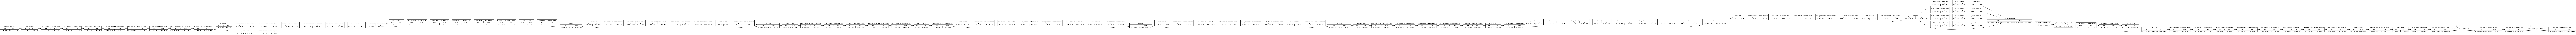

In [14]:
tf.keras.utils.plot_model(fastscnn, show_layer_names=True, show_shapes=True, dpi=300, rankdir='LR', to_file='./model_imgs/'+model+'.png')

In [13]:
callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.CSVLogger('./logs/'+model+'/logs/log'+time+'.csv'),
    keras.callbacks.TensorBoard(log_dir='./logs/'+model+'/tensorboard'),
    keras.callbacks.ModelCheckpoint('./logs/'+model+'/checkpoints/weights.{epoch:02d}-{val_loss:.2f}'+time+'.hdf5', 'val_loss', mode='min', save_best_only=True)
]

In [15]:
num_training = len(get_cityscapes_files(CITYSCAPES_ROOT, 'leftImg8bit', 'train', 'leftImg8bit'))
num_validation = len(get_cityscapes_files(CITYSCAPES_ROOT, 'leftImg8bit', 'val', 'leftImg8bit'))
history= fastscnn.fit(
        train_ds,
        epochs=1000,
        steps_per_epoch=np.ceil(num_training/BATCH_SIZE),
        validation_data=val_ds,
        validation_steps=np.ceil(num_validation/BATCH_SIZE),
        callbacks=callbacks,
        verbose=1
)

Train for 372.0 steps, validate for 63.0 steps
Epoch 1/1000
372/372 [==============================] - 657s 2s/step - loss: 1.4223 - accuracy: 0.5805 - meanIoU: 0.4755 - val_loss: 1.7129 - val_accuracy: 0.4386 - val_meanIoU: 0.4770
Epoch 2/1000
372/372 [==============================] - 665s 2s/step - loss: 1.1776 - accuracy: 0.6604 - meanIoU: 0.4755 - val_loss: 0.8806 - val_accuracy: 0.7152 - val_meanIoU: 0.4770
Epoch 3/1000
372/372 [==============================] - 629s 2s/step - loss: 1.1055 - accuracy: 0.6816 - meanIoU: 0.4755 - val_loss: 0.7154 - val_accuracy: 0.7609 - val_meanIoU: 0.4770
Epoch 4/1000
372/372 [==============================] - 629s 2s/step - loss: 1.0693 - accuracy: 0.6904 - meanIoU: 0.4755 - val_loss: 0.6453 - val_accuracy: 0.7803 - val_meanIoU: 0.4770
Epoch 5/1000
372/372 [==============================] - 637s 2s/step - loss: 1.0314 - accuracy: 0.7021 - meanIoU: 0.4755 - val_loss: 0.6721 - val_accuracy: 0.7695 - val_meanIoU: 0.4770
Epoch 6/1000
372/372 [======

KeyError: 'val_accuracy'

# Unet

In [43]:
import unet
time = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
model='unet'
unet = unet.unet()
optimizer = tf.keras.optimizers.SGD(momentum=0.99, lr=0.01)
unet.compile(loss='sparse_categorical_crossentropy', 
                 optimizer=optimizer, 
                 metrics=['accuracy', 
                          tf.keras.metrics.MeanIoU(num_classes=CLASSES, name="meanIoU")
                         ]
                )

In [44]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 6 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1024, 1024, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 512, 512, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(unet, show_layer_names=True, show_shapes=True, dpi=200, to_file='./model_imgs/'+model+'.png')

In [ ]:
callbacks=[
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.CSVLogger('./logs/'+model+'/logs/log'+time+'.csv'),
    keras.callbacks.TensorBoard(log_dir='./logs/'+model+'/tensorboard'),
    keras.callbacks.ModelCheckpoint('./logs/'+model+'/checkpoints/weights.{epoch:02d}-{val_loss:.2f}'+time+'.hdf5', 'val_loss', mode='min', save_best_only=True)
]

In [ ]:
num_training = len(get_cityscapes_files(CITYSCAPES_ROOT, 'leftImg8bit', 'train', 'leftImg8bit'))
num_validation = len(get_cityscapes_files(CITYSCAPES_ROOT, 'leftImg8bit', 'val', 'leftImg8bit'))
history= unet.fit_generator(
        train_generator,
        epochs=1000,
        steps_per_epoch=np.ceil(num_training/BATCH_SIZE),
        validation_data=val_generator,
        validation_steps=np.ceil(num_validation/BATCH_SIZE),
        callbacks=callbacks,
        verbose=1)

# Prediction with Sample Image

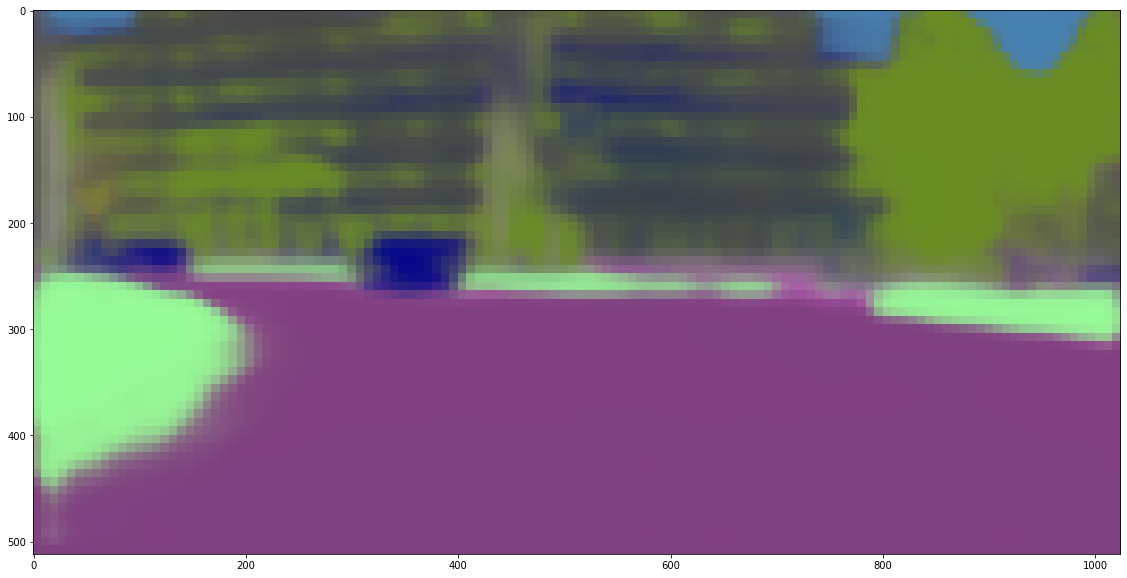

In [27]:
%matplotlib inline
image_file = '/home/skywatcher/datasets/data/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png'

#Get the byte string
image_string = tf.io.read_file(image_file)
#Turn the byte string into a tensor
image_test = tf.image.decode_png(image_string, channels=3)
image_test = tf.image.resize(image_test,TARGET_SIZE,method='nearest')

image_test = tf.image.convert_image_dtype(image_test, tf.float32)
fastscnn.load_weights('./logs/fastscnn/checkpoints/weights.09-0.5008-01-2020-11-10-09.hdf5')
prediction = fastscnn.predict(tf.reshape(image_test,shape=(1,512,1024,3)))
prediction = tf.reshape(prediction,(512,1024,19))
predict_img = np.matmul(prediction,CITYSCAPES_COLORS)
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(tf.cast(predict_img,tf.int32))
plt.show()

In [48]:
vgg16 = keras.applications.vgg16.VGG16(include_top=False, input_shape=(1024,1024,3), weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1024, 1024, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1024, 1024, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 512, 512, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 512, 512, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 512, 512, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 256, 256, 128)     0     